In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [4]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 14:09:29,039 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 14:09:29,042 INFO: Initializing external client
2025-11-18 14:09:29,042 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 14:09:30,977 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286353


In [6]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [7]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-18 14:09:36,570 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [8]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [9]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [10]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.42s) 


In [11]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2018-04-09 00:00:00+00:00,3.587834,7.3,16.704155,31.635977
1,2018-04-10 00:00:00+00:00,2.425333,0.2,17.283749,42.444206
2,2018-04-11 00:00:00+00:00,1.694083,0.0,13.979871,74.891174
3,2018-04-12 00:00:00+00:00,2.706583,0.0,15.111424,69.621513
4,2018-04-13 00:00:00+00:00,4.427416,0.0,16.039202,79.392876
...,...,...,...,...,...
2345,2025-04-26 00:00:00+00:00,5.044084,0.0,13.379461,329.325836
2346,2025-04-27 00:00:00+00:00,8.894082,0.0,19.361507,219.933044
2347,2025-04-28 00:00:00+00:00,11.877416,0.2,26.221373,259.602509
2348,2025-04-29 00:00:00+00:00,12.019084,0.3,20.343184,300.677185


In [12]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

## <span style="color:#ff5f27;">📊 Adding Lagged Features</span>

We will add lagged air quality features (1 day, 2 days, and 3 days ago) to improve model performance.


In [13]:
# Create lagged features by merging with historical PM2.5 values
# First, we need to get the air quality data with dates to create lags
air_quality_data = air_quality_fg.read()
air_quality_data = air_quality_data[['date', 'pm25']].sort_values('date').reset_index(drop=True)
air_quality_data['date'] = pd.to_datetime(air_quality_data['date']).dt.date

# Create lagged features (shift by 1, 2, 3 days)
air_quality_data['pm25_lag1'] = air_quality_data['pm25'].shift(1)
air_quality_data['pm25_lag2'] = air_quality_data['pm25'].shift(2)
air_quality_data['pm25_lag3'] = air_quality_data['pm25'].shift(3)

# Merge lagged features with training and test data
X_train_with_date = X_train.copy()
X_train_with_date['date'] = pd.to_datetime(X_train_with_date['date']).dt.date
X_train_lagged = pd.merge(X_train_with_date, air_quality_data[['date', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']], 
                          on='date', how='left')

X_test_with_date = X_test.copy()
X_test_with_date['date'] = pd.to_datetime(X_test_with_date['date']).dt.date
X_test_lagged = pd.merge(X_test_with_date, air_quality_data[['date', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']], 
                         on='date', how='left')

# Handle missing values: For rows where lagged features are NaN (beginning of time series),
# we fill with the mean of available values. This is reasonable since we don't have historical
# data for the very first few days. Alternative: could drop rows with missing lagged values.

# Calculate mean values from training data (to avoid data leakage)
mean_lag1 = X_train_lagged['pm25_lag1'].mean()
mean_lag2 = X_train_lagged['pm25_lag2'].mean()
mean_lag3 = X_train_lagged['pm25_lag3'].mean()

# Fill missing values with mean (for the first few rows that don't have historical data)
X_train_lagged['pm25_lag1'] = X_train_lagged['pm25_lag1'].fillna(mean_lag1)
X_train_lagged['pm25_lag2'] = X_train_lagged['pm25_lag2'].fillna(mean_lag2)
X_train_lagged['pm25_lag3'] = X_train_lagged['pm25_lag3'].fillna(mean_lag3)

# Use the same means for test set to maintain consistency
X_test_lagged['pm25_lag1'] = X_test_lagged['pm25_lag1'].fillna(mean_lag1)
X_test_lagged['pm25_lag2'] = X_test_lagged['pm25_lag2'].fillna(mean_lag2)
X_test_lagged['pm25_lag3'] = X_test_lagged['pm25_lag3'].fillna(mean_lag3)

# Prepare features with lagged values
X_features_lagged = X_train_lagged.drop(columns=['date'])
X_test_features_lagged = X_test_lagged.drop(columns=['date'])

print("Lagged features created successfully!")
print(f"Training features shape: {X_features_lagged.shape}")
print(f"Test features shape: {X_test_features_lagged.shape}")
print(f"\nLagged features columns: {[col for col in X_features_lagged.columns if 'lag' in col]}")
print(f"\nMissing values in lagged features (after fillna):")
print(f"  Training: {X_features_lagged[['pm25_lag1', 'pm25_lag2', 'pm25_lag3']].isna().sum().sum()}")
print(f"  Test: {X_test_features_lagged[['pm25_lag1', 'pm25_lag2', 'pm25_lag3']].isna().sum().sum()}")


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 
Lagged features created successfully!
Training features shape: (2350, 7)
Test features shape: (175, 7)

Lagged features columns: ['pm25_lag1', 'pm25_lag2', 'pm25_lag3']

Missing values in lagged features (after fillna):
  Training: 0
  Test: 0


## <span style="color:#ff5f27;">📈 Baseline Model (Without Lagged Features)</span>

First, let's train and evaluate the baseline model for comparison.


In [27]:
# Train baseline model (without lagged features)
xgb_baseline = XGBRegressor(random_state=42)
xgb_baseline.fit(X_features, y_train)

# Predict on test set
y_pred_baseline = xgb_baseline.predict(X_test_features)

# Calculate metrics
mse_baseline = mean_squared_error(y_test.iloc[:,0], y_pred_baseline)
r2_baseline = r2_score(y_test.iloc[:,0], y_pred_baseline)

print("=== Baseline Model Performance (Without Lagged Features) ===")
print(f"MSE: {mse_baseline:.4f}")
print(f"R²: {r2_baseline:.4f}")
print(f"RMSE: {np.sqrt(mse_baseline):.4f}")


=== Baseline Model Performance (Without Lagged Features) ===
MSE: 147.6358
R²: -0.6297
RMSE: 12.1505


## <span style="color:#ff5f27;">🚀 Model with Lagged Features</span>

Now let's train a model with the lagged features included.


In [28]:
# Train model with lagged features
xgb_lagged = XGBRegressor(random_state=42)
xgb_lagged.fit(X_features_lagged, y_train)

# Predict on test set
y_pred_lagged = xgb_lagged.predict(X_test_features_lagged)

# Calculate metrics
mse_lagged = mean_squared_error(y_test.iloc[:,0], y_pred_lagged)
r2_lagged = r2_score(y_test.iloc[:,0], y_pred_lagged)

print("=== Model Performance (With Lagged Features) ===")
print(f"MSE: {mse_lagged:.4f}")
print(f"R²: {r2_lagged:.4f}")
print(f"RMSE: {np.sqrt(mse_lagged):.4f}")


=== Model Performance (With Lagged Features) ===
MSE: 65.4487
R²: 0.2775
RMSE: 8.0900


<Figure size 1000x600 with 0 Axes>

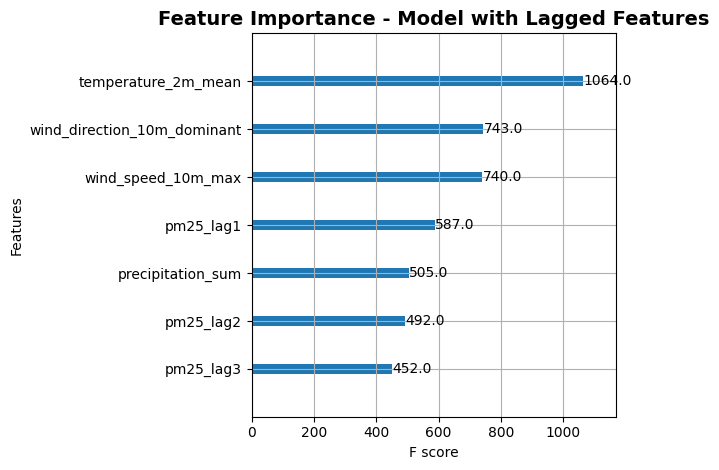


Top 10 Most Important Features (with lagged features):
  temperature_2m_mean: 1064.0
  wind_direction_10m_dominant: 743.0
  wind_speed_10m_max: 740.0
  pm25_lag1: 587.0
  precipitation_sum: 505.0
  pm25_lag2: 492.0
  pm25_lag3: 452.0


In [29]:
images_dir = 'air_quality_model/images'
# Visualize feature importance for the model with lagged features
plt.figure(figsize=(10, 6))
plot_importance(xgb_lagged, max_num_features=10)
plt.title('Feature Importance - Model with Lagged Features', fontsize=14, fontweight='bold')
plt.tight_layout()
feature_importance_lagged_path = images_dir + "/feature_importance_lagged.png"
plt.savefig(feature_importance_lagged_path)
plt.show()

# Compare feature importances
print("\nTop 10 Most Important Features (with lagged features):")
feature_importance = xgb_lagged.get_booster().get_score(importance_type='weight')
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
for feature, importance in sorted_features:
    print(f"  {feature}: {importance}")


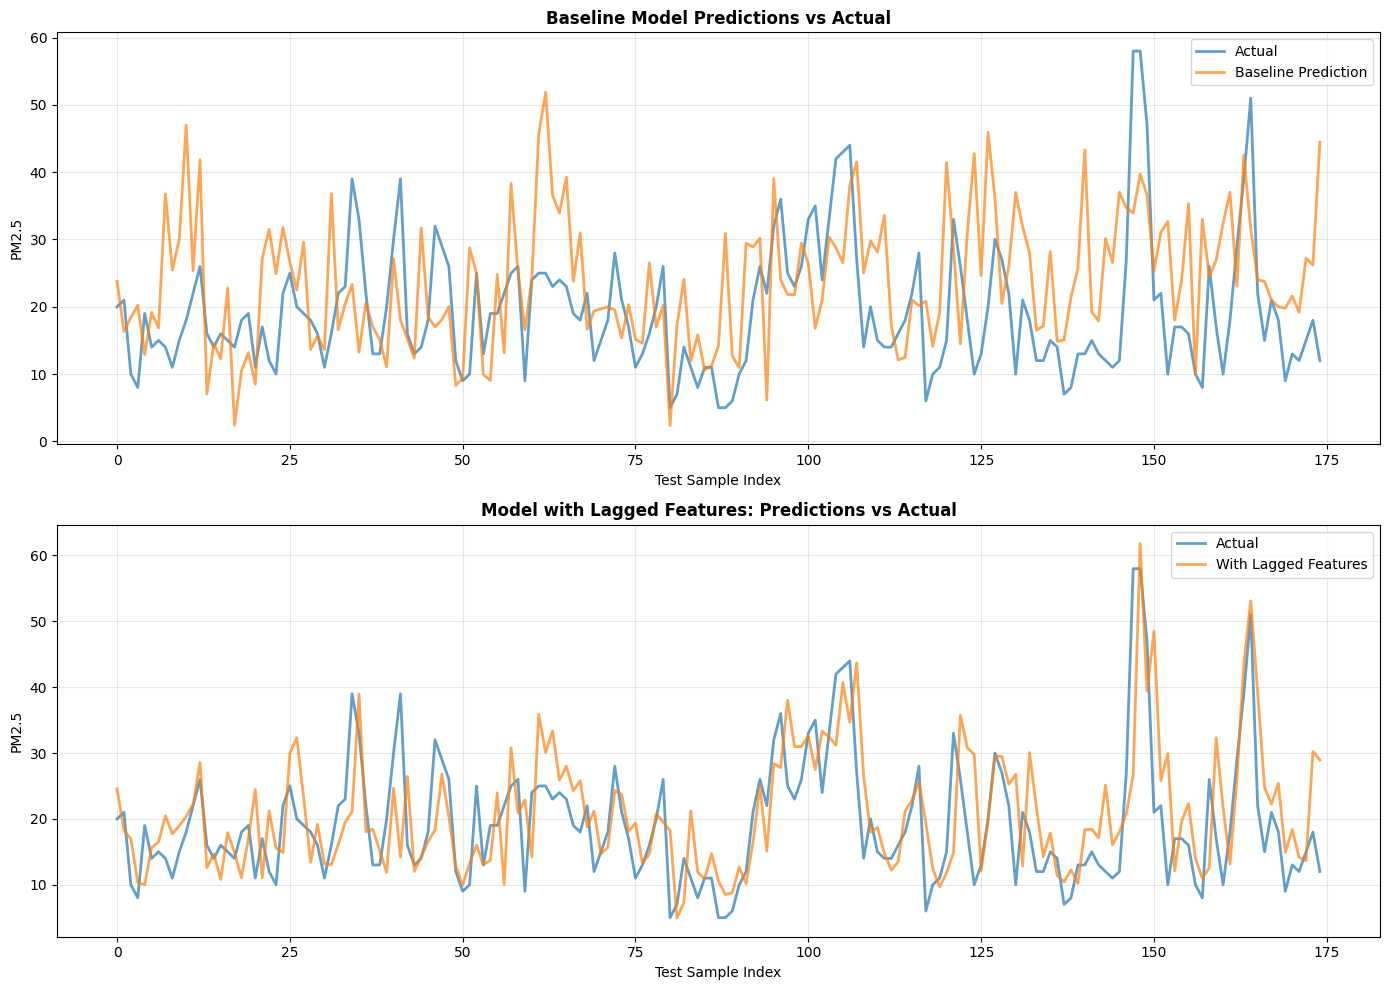

In [30]:
# Create visualization comparing predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Baseline predictions
axes[0].plot(range(len(y_test)), y_test.iloc[:,0], label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(range(len(y_test)), y_pred_baseline, label='Baseline Prediction', linewidth=2, alpha=0.7)
axes[0].set_title('Baseline Model Predictions vs Actual', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Test Sample Index')
axes[0].set_ylabel('PM2.5')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Model with lagged features
axes[1].plot(range(len(y_test)), y_test.iloc[:,0], label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(range(len(y_test)), y_pred_lagged, label='With Lagged Features', linewidth=2, alpha=0.7)
axes[1].set_title('Model with Lagged Features: Predictions vs Actual', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Test Sample Index')
axes[1].set_ylabel('PM2.5')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
comparison_plot_path = images_dir + "/model_comparison.png"
plt.savefig(comparison_plot_path)
plt.show()


In [31]:
y_train

,pm25
0,55.0
1,14.0
2,23.0
3,26.0
4,33.0
...,...
2345,13.0
2346,17.0
2347,28.0
2348,14.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [32]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 147.63582
R squared: -0.6297111708468479


## <span style="color:#ff5f27;">💾 Save Improved Model with Lagged Features</span>

Save the model with lagged features to the model registry for comparison.


In [36]:
# Save the improved model with lagged features
model_dir = 'air_quality_model'
xgb_lagged.save_model(model_dir + "/model_lagged.json")

# Create metrics dictionary for the improved model
res_dict_lagged = { 
    "MSE": str(mse_lagged),
    "R squared": str(r2_lagged),
    # "RMSE": str(np.sqrt(mse_lagged)),
    # "MSE_baseline": str(mse_baseline),
    # "R_squared_baseline": str(r2_baseline),
    # "MSE_improvement_percent": f"{mse_improvement:.2f}%",
    # "R_squared_improvement": f"{r2_improvement:.4f}",
    # "features": "weather + lagged_pm25_1_2_3_days"
}
mr = project.get_model_registry()
# Save improved model to registry
aq_model_lagged = mr.python.create_model(
    name="air_quality_xgboost_model_lagged", 
    metrics=res_dict_lagged,
    feature_view=feature_view,  # Note: You may want to create a new feature view with lagged features
    description="Air Quality (PM2.5) predictor with lagged features (1, 2, 3 days)",
)

# Save the model artifacts
aq_model_lagged.save(model_dir + "/model_lagged.json")
print(f"\n✅ Improved model saved to registry!")
print(f"Model: {aq_model_lagged.name}, Version: {aq_model_lagged.version}")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/air_quality_model/model_lagged.json: 0.000%|         …

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/model_schema.json: 0.000%|          | 0/572 elapsed<0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286353/models/air_quality_xgboost_model_lagged/1

✅ Improved model saved to registry!
Model: air_quality_xgboost_model_lagged, Version: 1


In [37]:
df = y_test
df['predicted_pm25'] = y_pred

In [38]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
2350,20.0,23.787733,2025-05-01 00:00:00+00:00
2351,21.0,16.326185,2025-05-02 00:00:00+00:00
2352,10.0,18.410437,2025-05-03 00:00:00+00:00
2353,8.0,20.192780,2025-05-04 00:00:00+00:00
2354,19.0,12.872837,2025-05-05 00:00:00+00:00


In [39]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

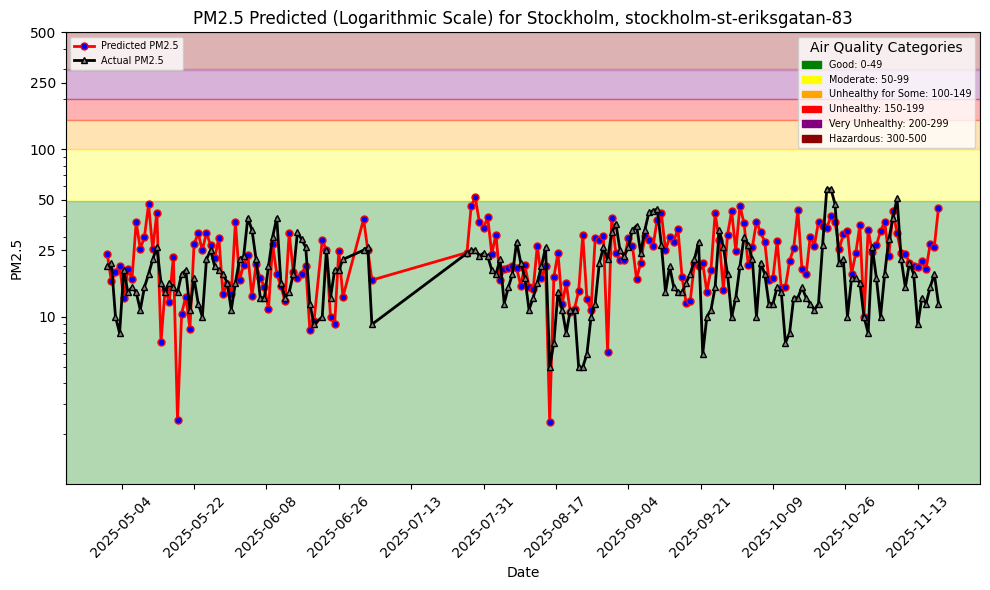

In [40]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

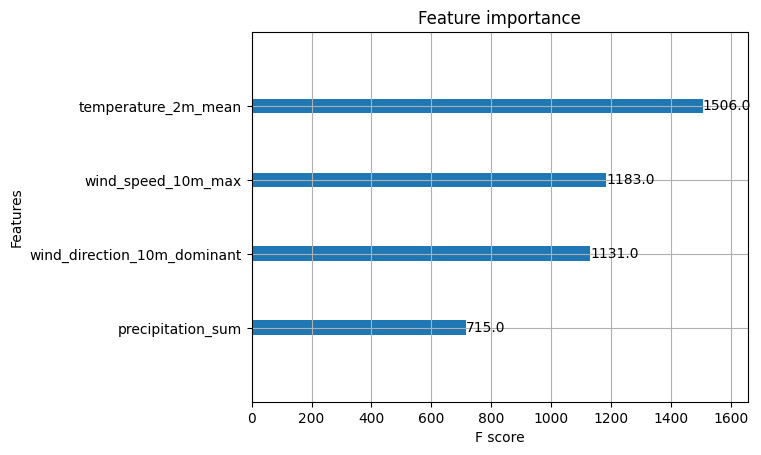

In [41]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [42]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [43]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [44]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/air_quality_model/model.json: 0.000%|          | 0/51…

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/air_quality_model/model_lagged.json: 0.000%|         …

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/air_quality_model/images/feature_importance.png: 0.00…

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/air_quality_model/images/feature_importance_lagged.pn…

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/air_quality_model/images/model_comparison.png: 0.000%…

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/air_quality_model/images/pm25_hindcast.png: 0.000%|  …

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/model_schema.json: 0.000%|          | 0/572 elapsed<0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286353/models/air_quality_xgboost_model/4


Model(name: 'air_quality_xgboost_model', version: 4)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
